# Conformal prediction for regression

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

from sklearn.datasets import fetch_california_housing
from mapie.regression import MapieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [69]:
random_state = 42
np.random.seed(random_state)
epsilon = 0.05
mu, sigma, n_samples, noise = 0, 5, 100, 1

In [70]:
def target_function(X):
    return X * np.sin(X) * np.cos(X)

def create_regression_data(mu,sigma, n_samples, noise):
    X_train = np.random.normal(mu,sigma,n_samples).reshape(-1,1)
    X_test = np.arange(mu - 2*sigma, mu + 2*sigma, sigma/2).reshape(-1,1)
    
    y_train = target_function(X_train) + np.random.normal(0,
                                                          noise,
                                                          X_train.shape[0])[:,None]
    y_test = target_function(X_test) + np.random.normal(0,
                                                        noise,
                                                        X_test.shape[0])[:,None]

    return (
        X_train,
        X_test,
        y_train.ravel(),
        y_test.ravel()
    )

X_train,X_test,y_train,y_test = create_regression_data(mu,
                                                       sigma,
                                                       n_samples,
                                                       noise)

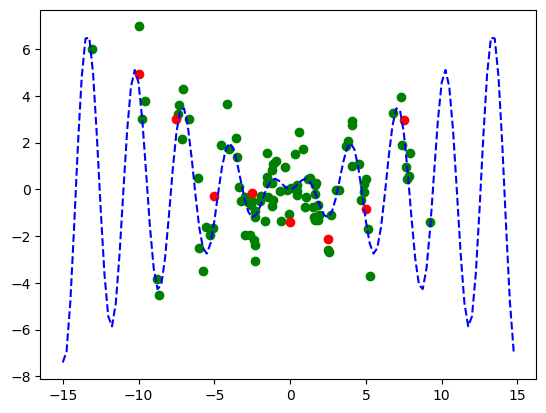

In [71]:
X_general = np.arange(mu - 3*sigma, mu + 3*sigma, step = sigma/20)
norm_quantile = sps.norm.ppf(1 - epsilon) 


fig,ax = plt.subplots()

ax.plot(X_general,target_function(X_general), color="blue",ls="--",label="ground_truth")
ax.scatter(X_train,y_train,color="green",label="train_data")
ax.scatter(X_test,y_test,color="red",label="testing data")
plt.show()

We now discuss Conformal prediction applied to regression tasks. We recommend reading the Chapter on Conformal Classification (Section ....) as it covers the general idea. Regression is done through inductive conformal prediction which can be briefly described as follows:
1. Split the data into a training set and calibration set.
2. Train a arbitrary machine learning model on the training set
3. Calculate the non-conformity scores for the calibration set
4. Use these value to create a prediction interval for each new observation.

The non-conformity function $f$ can be seen as the ''weirdness' of a label $y$ given the features $x$.
In the following we will introduce the *Split*-Method for constructing the non-conformity scores.
We split the data into $l$ training, $k$ validation and $N-k-l$ testing data points.
## Split-Method

In [72]:
X_train_prefit,X_val_prefit,y_train_prefit,y_val_prefit = train_test_split(X_train,y_train,
                                               train_size=0.8,
                                               random_state=random_state)

For the non-conformity function $f$ we use the *absolute residual score* one of the most commonly used non-conformity score functions:

$$
    f(x,y) = | y - \hat{h}(x) |
$$

where $\hat{h}$ is the underlying machine learning model we use.
Applying this to the validation dataset consisting of $k$ data points yields a sequence of scores:
$$
\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k} , \enspace .

$$


In [73]:
model = GradientBoostingRegressor(
    loss="squared_error", random_state=random_state
)  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
model.fit(X_train_prefit,y_train_prefit)

# construct the sequence of residuals
residuals = np.abs(y_val_prefit - model.predict(X_val_prefit))
residuals

array([0.53065627, 0.02530395, 0.44441471, 0.91835082, 0.01583598,
       0.88212149, 1.51732778, 1.04360832, 1.84785043, 0.78802113,
       1.14127663, 1.57308448, 0.88439285, 0.41002652, 0.23721309,
       0.16430728, 0.18840022, 1.55254996, 0.35501317, 2.88390304])

To build the prediction intervals we again construct a prediction interval based on the $1-\epsilon$ Quantile q. Instead of incorporating the new data point prediction in finding the Quantile q (which is done in classification), conformal prediction regression only computes q on the validation set:

$$
        q = (1-\epsilon) \text{-quantile of the sequence }(\alpha_{l+1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})

$$

The resulting prediction interval for a new data point $x_{N+1}$ is constructed, through $\hat{h}(x_{N+1})\pm q$.

In [74]:
conformal_quantile = np.quantile(residuals, np.ceil((1-epsilon)*(len(residuals)+1))/len(residuals), method="higher")
conformal_quantile

2.883903038235819

In [75]:
predictions = model.predict(X_test)

prediction_lower = predictions - conformal_quantile
prediction_higher = predictions + conformal_quantile
prediction_interval = np.dstack((prediction_lower,prediction_higher))

prediction_interval

array([[[ 3.95320089,  9.72100696],
        [ 0.3387341 ,  6.10654017],
        [-4.41639671,  1.35140937],
        [-3.8923055 ,  1.87550058],
        [-2.89290386,  2.87490222],
        [-4.71296026,  1.05484581],
        [-2.8223264 ,  2.94547968],
        [-1.05465767,  4.71314841]]])

The identical behaviour can be done using the [MAPIE](https://mapie.readthedocs.io/en/latest/index.html) package.

In [76]:
conformel_model = MapieRegressor(estimator=model,
                                 method="base",
                                 cv="prefit",
                                 random_state=random_state)
conformel_model.fit(X_val_prefit,y_val_prefit)
y_pred, y_interval = conformel_model.predict(X_test,
                                             alpha=0.05)
y_interval = y_interval.reshape(-1,2)
y_interval

array([[ 3.95320089,  9.72100696],
       [ 0.3387341 ,  6.10654017],
       [-4.41639671,  1.35140937],
       [-3.8923055 ,  1.87550058],
       [-2.89290386,  2.87490222],
       [-4.71296026,  1.05484581],
       [-2.8223264 ,  2.94547968],
       [-1.05465767,  4.71314841]])

```{note}
    The MAPIE package supports predicting the intervals with multiple alpha/epsilon values. Therefore only using one alpha/epsilon value, the output can be reshaped to get rid of the third dimension which would be equal to the number of alpha/epsilon values.
```

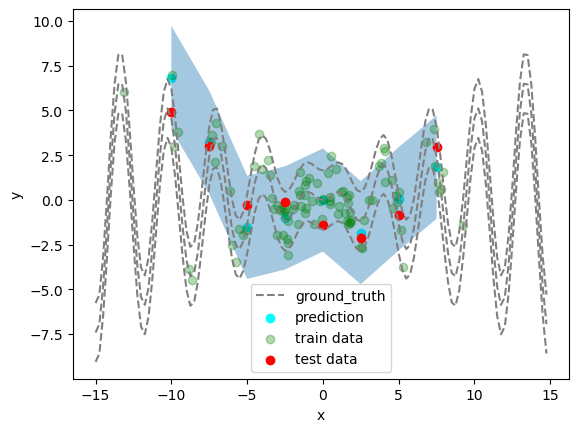

In [77]:
def plot_data(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,              
    y_pred_interval,
    norm_quantile,
    noise):
    
    fig, ax = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # plot the true relationship with confidence intervals
    ax.plot(
        X_general, target_function(X_general), color="gray", ls="--", label="ground_truth"
    )
    ax.plot(X_general, target_function(X_general) - norm_quantile * noise, color="gray", ls="--")
    ax.plot(X_general, target_function(X_general) + norm_quantile * noise, color="gray", ls="--")


    # plot the prediction plus the interval
    ax.scatter(X_test,y_pred,color="aqua", label="prediction")
    ax.fill_between(X_test.ravel(), y_pred_interval[:,0].ravel(), y_pred_interval[:,1].ravel(), alpha=.4)


    ax.scatter(X_train, y_train, color="green", label="train data", alpha=.3)
    ax.scatter(X_test, y_test, color="red", label="test data")

    ax.legend()
    plt.show()
    
plot_data(X_train=X_train,
          X_test= X_test,
          y_train=y_train,
          y_test=y_test,
          y_pred=y_pred,
          y_pred_interval=y_interval,
          norm_quantile=norm_quantile,
          noise=noise)

## Split Method without Prefit
In the following chapters we will only use the MAPIE package without prefitting our model to the training data. MAPIE then applies its method over multiple iterations (controlled through cv) to have a more stable result.
More on the cv parameter can find on the corresponding [documentation](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor).

In [78]:
conformel_model = MapieRegressor(
    estimator=model, method="base", cv=5, random_state=random_state
)
conformel_model.fit(X_train, y_train)
y_pred, y_interval = conformel_model.predict(X_test, alpha=0.05)
y_interval = y_interval.reshape(-1, 2)
y_interval

array([[ 3.92138895,  9.68919503],
       [ 0.24060924,  6.00841531],
       [-4.49004253,  1.27776355],
       [-3.85387223,  1.91393384],
       [-2.79420075,  2.97360532],
       [-4.98582154,  0.78198454],
       [-2.80773857,  2.9600675 ],
       [-1.15608776,  4.61171832]])

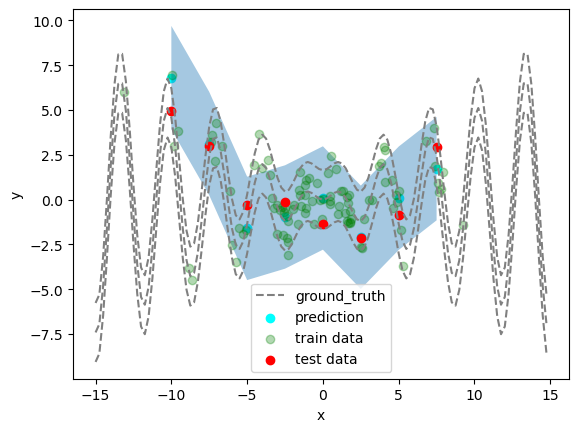

In [79]:
plot_data(X_train=X_train,
          X_test= X_test,
          y_train=y_train,
          y_test=y_test,
          y_pred=y_pred,
          y_pred_interval=y_interval,
          norm_quantile=norm_quantile,
          noise=noise)

## Jackknife Method


Main idea:
1. For each training instance $i = 1, \dots, l+k$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, l+k$ models $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i = y_i - \hat{h}_{-i}$.
3. Based on these scores $\alpha_1, \dots, \alpha_{l+k}$ the corresponding quantile $ q_{jack} =(1-\epsilon) \text{-quantile of the sequence }(\alpha_{1}, \, \alpha_{l+2}, \ldots , \alpha_{l+k})$ is calculated.
4. The prediction interval for a new instance $x_{N+1}$ is calculated through $\pm \ q_{jack}$:
$$
    [\hat{h}(x_{N+1}) - q , \hat{h}(x_{N+1}) + q]
$$

In [80]:
conformel_model = MapieRegressor(
    estimator=model, method="base", cv=5, random_state=random_state
)
conformel_model.fit(X_train, y_train)
y_pred, y_interval = conformel_model.predict(X_test, alpha=0.05)
y_interval = y_interval.reshape(-1, 2)
y_interval

array([[ 3.92138895,  9.68919503],
       [ 0.24060924,  6.00841531],
       [-4.49004253,  1.27776355],
       [-3.85387223,  1.91393384],
       [-2.79420075,  2.97360532],
       [-4.98582154,  0.78198454],
       [-2.80773857,  2.9600675 ],
       [-1.15608776,  4.61171832]])